![alt text](http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png 'UCI_data_science')

# Feature Engineering

|Session | Session |
|-----------|---------|
|Feature Engineering I     | Feature Transformation and Dimension Reduction (PCA)|
|Feature Engineering II    | Nonlinear Dimension Reduction (Autoencoder)|
|Feature Engineering III   | Random Projections |


# Goals of this Lesson
- Feature Transformations
    - Standard Normal Transform
    - Domain-Specific Transform
    - Mystery Transform
    
- Dimensionality Reduction
    - PCA: Model and Learning
    - PCA for Images
    - PCA for Visualization

## References 
- Chapter 14 of [*Elements of Statistical Learning* by Hastie, Tibshirani, Friedman](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf)
- [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- [SciKit-Learn's documentation on data preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)
- [SciKit-Learn's documentation on dimensionality reduction](http://scikit-learn.org/stable/modules/decomposition.html#decompositions)

## 0.  Preliminaries
First we need to import Numpy, Pandas, MatPlotLib...

In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

I've created a function that we'll use later to create visualizations.  It is a bit messy and not essential to the material so don't worry about understanding it.  I'll be happy to explain it to anyone interested during a break or after the session.  

In [14]:
from matplotlib.colors import ListedColormap

# Another messy looking function to make pretty plots of basketball courts
def visualize_court(log_reg_model, coord_type='cart', court_image = '../data/nba/nba_court.jpg'):
    two_class_cmap = ListedColormap(['#FFAAAA', '#AAFFAA']) # light red for miss, light green for make
    x_min, x_max = 0, 50 #width (feet) of NBA court
    y_min, y_max = 0, 47 #length (feet) of NBA half-court
    grid_step_size = 0.2
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, grid_step_size), np.arange(y_min, y_max, grid_step_size))
    features = np.c_[grid_x.ravel(), grid_y.ravel()]
    # change coordinate system
    if coord_type == 'polar':
        features = np.c_[grid_x.ravel(), grid_y.ravel()]
        hoop_location = np.array([25., 0.])
        features -= hoop_location
        dists = np.sqrt(np.sum(features**2, axis=1))
        angles = np.arctan2(features[:,1], features[:,0])
        features = np.hstack([dists[np.newaxis].T, angles[np.newaxis].T])
        
    grid_predictions = log_reg_model.predict(features)
    grid_predictions = grid_predictions.reshape(grid_x.shape)
    fig, ax = plt.subplots()
    court_image = plt.imread(court_image)
    ax.imshow(court_image, interpolation='bilinear', origin='lower',extent=[x_min,x_max,y_min,y_max])
    ax.imshow(grid_predictions, cmap=two_class_cmap, interpolation = 'nearest',
              alpha = 0.60, origin='lower',extent=[x_min,x_max,y_min,y_max])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title( "Make / Miss Prediction Boundaries" )
    plt.show()

We also need functions for shuffling the data and calculating classification errrors.  

In [4]:
### function for shuffling the data and labels
def shuffle_in_unison(features, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(features)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

## 1.  Warm-up

Let's start with a warm-up exercise.  In the data directory you'll find a dataset of recent movies and their ratings according to several popular websites.  Let's load it with Pandas...  

In [7]:
# load a dataset of recent movies and their ratings across several websites
movie_data = pd.read_csv('../data/movie_ratings.csv')
# reduce it to just the ratings categories
movie_data = movie_data[['FILM','RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue', 'IMDB']]
movie_data.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,Fandango_Ratingvalue,IMDB
0,Avengers: Age of Ultron (2015),74,86,66,7.1,4.5,7.8
1,Cinderella (2015),85,80,67,7.5,4.5,7.1
2,Ant-Man (2015),80,90,64,8.1,4.5,7.8
3,Do You Believe? (2015),18,84,22,4.7,4.5,5.4
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,3.0,5.1


In [8]:
movie_data.describe()

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,Fandango_Ratingvalue,IMDB
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,60.849315,63.876712,58.808219,6.519178,3.845205,6.736986
std,30.168799,20.024430,19.517389,1.510712,0.502831,0.958736
min,5.000000,20.000000,13.000000,2.400000,2.700000,4.000000
25%,31.250000,50.000000,43.500000,5.700000,3.500000,6.300000
50%,63.500000,66.500000,59.000000,6.850000,3.900000,6.900000
75%,89.000000,81.000000,75.000000,7.500000,4.200000,7.400000
max,100.000000,94.000000,94.000000,9.600000,4.800000,8.600000


### Logistic Regression Review

_**Data**_

We observe pairs $(\mathbf{x}_{i},y_{i})$ where
\begin{eqnarray*}
y_{i} \in \{ 0, 1\} &:& \mbox{class label} \\
\mathbf{x}_{i} = (x_{i,1}, \dots, x_{i,D}) &:& \mbox{set of $D$ explanatory variables (aka features)} 
\end{eqnarray*}

_** Parameters**_

\begin{eqnarray*}
\mathbf{\beta}^{T} = (\beta_{0}, \dots, \beta_{D}) : \mbox{values encoding the relationship between the features and label}
\end{eqnarray*}

_** Transformation Function **_

\begin{equation*}
f(z_{i}=\mathbf{x}_{i} \mathbf{\beta} ) = (1+e^{-\mathbf{x}_{i} \mathbf{\beta} })^{-1}
\end{equation*}

_**Error Function**_

\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} -y_{i} \log f(\mathbf{x}_{i} \mathbf{\beta} ) - (1-y_{i}) \log (1-f(\mathbf{x}_{i} \mathbf{\beta} ))
\end{eqnarray*}

_** Learning $\beta$ **_
- Randomly initialize $\beta$
- Until $\alpha || \nabla \mathcal{L} || < tol $:
    - $\mathbf{\beta}_{t+1} = \mathbf{\beta}_{t} - \alpha \nabla_{\mathbf{\beta}} \mathcal{L}$

## <span style="color:red">STUDENT ACTIVITY (10 MINS)</span> 
Let's run a logistic regression classifier on this data via SciKit-Learn.  If you need a refresher, [check out the notebook from the first course](https://github.com/UCIDataScienceInitiative/PredictiveModeling_withPython/blob/master/Solutions/Session%203%20-%20Solutions.ipynb) and the [SciKit-Learn documentation on logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).  The goal is to predict if the *IMDB* rating is under or over 7/10, using the other ratings as features.  I've started the code.  You just need to fill-in the lines for training and computing the error.  Note there is no test set yet.

In [9]:
from sklearn.linear_model import LogisticRegression

# set the random number generator for reproducability
np.random.seed(123)

# let's try to predict the IMDB rating from the others
features = movie_data[['RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue']].as_matrix()
# create classes: more or less that 7/10 rating
labels = (movie_data['IMDB'] >= 7.).astype('int').tolist()
shuffle_in_unison(features, labels)

### Your Code Goes Here ###

# initialize and train a logistic regression model

# compute error on training data

model_LogReg = LogisticRegression()
model_LogReg.fit(features, labels)
predicted_labels = model_LogReg.predict(features)
train_error_rate = calc_classification_error(predicted_labels, labels)


###########################

print "Classification error on training set: %.2f%%" %(train_error_rate*100)
# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %((sum(labels)*100.)/len(labels))

Classification error on training set: 9.59%
Baseline Error: 46.58%


## 2.  Feature Transformations
Good features are crucial for training well-performing classifiers: 'garbage in, garbage out.'  In this section we introduce several transformations that are commonly applied to data as a preprocessing step before training a classifier.

### 2.1 Normal Standardization
Recall the formula of the standard linear model: $$\hat Y = f(\beta^{T} \mathbf{X}) $$ where $\hat Y$ is the predictions, $f(\cdot)$ is the transformation function, $\beta$ is the weights (parameters), and $X$ is the $N \times D$ matrix of features.  For simplicity, assume there are just two features: $$ \beta^{T} \mathbf{x}_{i} = \beta_{1}x_{i,1} + \beta_{2}x_{i,2}.$$  Usually $x_{i,1}$ and $x_{i,2}$ will be measured in different units.  For instance, in the movie ratings data, the Rotten Tomatoes dimension is on a $0-100$ scale and the Fandango ratings are on $0-5$.  The difference in scale causes one dimension to dominate the inner product.  Linear models can learn to cope with this imbalance by changing the scales of the weights accordingly, but this makes optimization harder because gradient steps are unequal across dimensions.

One way to get rid of hetergeneous scales is to standardize the data so that the values in each dimension are distributed according to the standard Normal distribution.  In math, this means we'll transform the data like so: $$\mathbf{X}_{std} = \frac{\mathbf{X} - \boldsymbol{\mu}_{X}}{\boldsymbol{\sigma}_{X}}. $$  This is also called 'z-score scaling.'  Let's examine the affect of this transformation on training error.

In [10]:
# perform z-score scaling
features_mu = np.mean(features, axis=0)
features_sigma = np.std(features, axis=0)
std_features = (features - features_mu)/features_sigma

# re-train model
lm = LogisticRegression()
lm.fit(std_features, labels)

### compute error on training data
predictions = lm.predict(std_features)
print "Classification error on training set: %.3f%%" %(calc_classification_error(predictions, labels)*100)
# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %((sum(labels)*100.)/len(labels))

Classification error on training set: 7.534%
Baseline Error: 46.58%


Standard Normal scaling is a common and usually default first step, especially when you know the data in measured in different units.

### 2.2 Domain-Specific Transformations
Sometimes the data calls for a specific transformation.  We'll demonstrate this on the NBA dataset used in our first workshop.  Let's load it...

In [12]:
nba_shot_data = pd.read_csv('../data/nba/NBA_xy_features.csv')
nba_shot_data.head()

,x_Coordinate,y_Coordinate,shot_outcome
0,26.0,32.0,0.0
1,25.0,24.0,0.0
2,25.0,6.0,1.0
3,40.0,7.0,1.0
4,12.0,13.0,1.0


And let's run logistic regression on the data just as we did before...

Training ended after 0.49 seconds.
Classification Error on the Test Set: 41.87%
Baseline Error: 45.79%


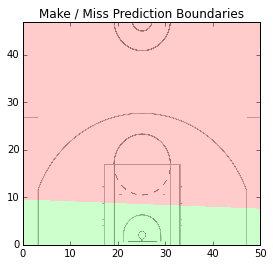

In [15]:
# split data into train and test
train_set_size = int(.80*len(nba_shot_data))
train_features = nba_shot_data.ix[:train_set_size,['x_Coordinate','y_Coordinate']].as_matrix()
test_features = nba_shot_data.ix[train_set_size:,['x_Coordinate','y_Coordinate']].as_matrix()
train_class_labels = nba_shot_data.ix[:train_set_size,['shot_outcome']].as_matrix()
test_class_labels = nba_shot_data.ix[train_set_size:,['shot_outcome']].as_matrix()

#Train logistic regression model
start_time = time.time()
lm.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = lm.predict(test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# visualize the boundary on the basketball court
visualize_court(lm)

Now let's transform the Cartesian coordinates into *polar* coordinates: (x,y) --> (radius, angle)...  

In [16]:
### Transform coordinate system

# radius coordinate: calculate distance from point to hoop
hoop_location = np.array([25.5, 0.])
train_features -= hoop_location
test_features -= hoop_location
train_dists = np.sqrt(np.sum(train_features**2, axis=1))
test_dists = np.sqrt(np.sum(test_features**2, axis=1))

# angle coordinate: use arctan2 function
train_angles = np.arctan2(train_features[:,1], train_features[:,0])
test_angles = np.arctan2(test_features[:,1], test_features[:,0])

# combine vectors into polar coordinates
polar_train_features = np.hstack([train_dists[np.newaxis].T, train_angles[np.newaxis].T])
polar_test_features = np.hstack([test_dists[np.newaxis].T, test_angles[np.newaxis].T])

pd.DataFrame(polar_train_features, columns=["Radius","Angle"]).head()

,Radius,Angle
0,32.003906,1.555173
1,24.005208,1.591627
2,6.020797,1.653938
3,16.101242,0.449760
4,18.741665,2.375060


Training ended after 0.54 seconds.
Classification Error on the Test Set: 40.92%
Baseline Error: 45.79%


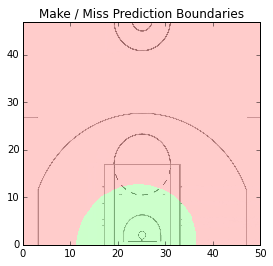

In [17]:
#Train model
start_time = time.time()
lm.fit(polar_train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on test data
predictions = lm.predict(polar_test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# visualize the boundary on the basketball court
visualize_court(lm, coord_type='polar')

## <span style="color:red">STUDENT ACTIVITY (10 mins)</span> 

## 2.3  Mystery Data
The data folder contains some mysterious data that can't be modeled well with a linear function.  Running the code below, we see the squared error is over 70.  However, the error can be driven to zero using one of two transformations.  See if you can find one or both.  The transformations are common ones you surely know.  

In [24]:
from sklearn.linear_model import LinearRegression

# load (x,y) where y is the mystery data
x = np.arange(0, 30, .2)[np.newaxis].T
y = np.load(open('../data/mystery_data.npy','rb'))

### transformation goes here ###

x = np.cos(x)

################################

# initialize regression model
lm = LinearRegression()
lm.fit(x,y)
y_hat = lm.predict(x)
squared_error = np.sum((y - y_hat)**2)

if not np.isclose(squared_error,0):
    print "The squared error should be zero!  Yours is %.8f." %(squared_error)
else:
    print "You found the secret transformation!  Your squared error is %.8f." %(squared_error)

You found the secret transformation!  Your squared error is 0.00000000.


## 3.  Dimensionality Reduction
Sometimes the data calls for more aggressive transformations.  High-dimensional data is usually hard to model because classifiers are likely to [overfit](https://en.wikipedia.org/wiki/Overfitting).  Regularization is one way to combat high dimensionality, but often it can not be enough.  This section will cover *dimensionality reduction*--a technique for reducing the number of features while still preserving curcial information.  This is a form of unsupervised learning since we use no class information.    

### 3.1 Image Dataset: [Bob Ross](https://en.wikipedia.org/wiki/Bob_Ross) Paintings
![alt text](http://i2.wp.com/espnfivethirtyeight.files.wordpress.com/2014/04/bob-ross1.jpg?quality=70&strip=all&w=600&ssl=1 'Bob_Ross_Banner')
In this section and throughout the next session, we'll use a dataset of [Bob Ross'](https://en.wikipedia.org/wiki/Bob_Ross) paintings.  Images are a type of data that notoriously have redundant features and whose dimensionality can be reduced significantly, without much loss of information.  We'll explore this phenomenom via 403 $400 \times 300$ full-color images of natural landscape paintings.

Before we load the data, let's take a minute to review how image data is stored on a computer.  Of course, all the computer sees are numbers ranging from 0 to 255.  Each pixel takes on one of these values.  Furthermore, there are three layers to color images--one for red, blue, and green values.  Therefore, the painting we'll examine are represented as $300 \times 400 \times 3$-dimensional tensors (multi-dimensional arrays).  This layering is depicted below.

![image_data_format](../graphics/image_data_format.png)

While images need to be represented with three dimensions to be visualized, the learning algorithms we'll consider don't need any notion of color values so I've already flattened the images into vector form, i.e. to create a matrix of size $403 \times 360000$.  Let's load the dataset...

In [26]:
# un-zip the paintings file
import zipfile
zipper = zipfile.ZipFile('../data/bob_ross/bob_ross_paintings.npy.zip')
zipper.extractall('../data/bob_ross/')

# load the 403 x 360,000 matrix
br_paintings = np.load(open('../data/bob_ross/bob_ross_paintings.npy','rb'))
print "Dataset size: %d x %d"%(br_paintings.shape)

Dataset size: 403 x 360000


and then visualize two of the images...

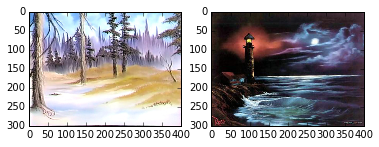

In [27]:
# subplot containing first image
ax1 = plt.subplot(1,2,1)
br_painting = br_paintings[70,:]
ax1.imshow(np.reshape(br_painting, (300, 400, 3)))

# subplot containing second image
ax2 = plt.subplot(1,2,2)
br_painting = br_paintings[33,:]
ax2.imshow(np.reshape(br_painting, (300, 400, 3)))
plt.show()

### 3.2 Principal Component Analysis

As we've seen, the dataset has many, many, many more features (columns) than examples (rows).  Simple Lasso or Ridge regularization probably won't be enough to prevent overfitting so we have to do something more drastic.  In this section, we'll cover [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), a popular technique for reducing the dimensionality of data.

#### Unsupervised Learning
PCA does not take into consideration labels, only the input features.  We can think of PCA as performing unsupervised 'inverse' prediction.  Our goal is: for a datapoint $\mathbf{x}_{i}$, find a lower-dimensional representation $\mathbf{h}_{i}$ such that $\mathbf{x}_{i}$ can be 'predicted' from $\mathbf{h}_{i}$ using a linear transformation.  In math, this statement can be written as $$\mathbf{\tilde x}_{i} = \mathbf{h}_{i} \mathbf{W}^{T} \text{ where } \mathbf{h}_{i} = \mathbf{x}_{i} \mathbf{W}. $$  $\mathbf{W}$ is a $D \times K$ matrix of parameters that need to be learned--much like the $\beta$ vector in regression models.  $D$ is the dimensionality of the original data, and $K$ is the dimensionality of the compressed representation $\mathbf{h}_{i}$.  The graphic below reiterates the above described PCA pipline: 

![pca_pipeline](../graphics/pca_pipeline.png)

#### Optimization
Having defined the PCA model, we look to write learning as an optimization process.  Recall that we wish to make a reconstruction of the data, denoted $\mathbf{\tilde x}_{i}$, as close as possible to the original input: $$\mathcal{L} = \sum_{i=1}^{N} (\mathbf{x}_{i} - \mathbf{\tilde x}_{i})^{2}.$$  We can make a substitution for $\mathbf{\tilde x}_{i}$ from the equation above: $$ = \sum_{i=1}^{N} (\mathbf{x}_{i} - \mathbf{h}_{i}\mathbf{W}^{T})^{2}.$$  And we can make another substitution for $\mathbf{h}_{i}$, bringing us to the final form of the loss function: $$ = \sum_{i=1}^{N} (\mathbf{x}_{i} - \mathbf{x}_{i}\mathbf{W}\mathbf{W}^{T})^{2}.$$   

We could perform gradient descent on $\mathcal{L}$, just like we do for logistic regression models, but there exists a deterministic solution.  We won't show the derivation here, but you can find it [here](http://stats.stackexchange.com/questions/32174/pca-objective-function-what-is-the-connection-between-maximizing-variance-and-m).  $\mathbf{W}$ is optimal when it contains the eigenvectors of the data's covariance matrix, and thus we can use a standard eigen decomposition to learn the transform: $$ \boldsymbol{\Sigma}_{\mathbf{X}} = \mathbf{W} \boldsymbol{\Lambda} \boldsymbol{W}^{T} $$ where $\boldsymbol{\Sigma}_{\mathbf{X}}$ is the data's empirical covariance matrix and $\boldsymbol{\Lambda}$ is a diagonal matrix of eigenvalues.  Eigen decompositions can be performed effeciently by any scientific computing library, including [numpy](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html#numpy.linalg.eig).   

#### Intuition
The connection to the data's (co-)variance becomes a little more clear when the intuitions behind PCA are examined.  The PCA transformation projects the data onto linear subspaces oriented in the directions of highest variance.  To elaborate, assume the data resides in two dimensions according to the following scatter plot.  The columns of $\mathbf{W}$--the $K=2$ principal components--would be the green lines below:
![alt text](http://weigend.com/files/teaching/stanford/2008/stanford2008.wikispaces.com/file/view/pca_example.gif)
'PCA 1st Dimension' is the direction of greatest variance, and if the data is projected down to one dimension, the new representations would be produced by collapsing the data onto that line.

#### Principal Component Analysis (PCA) Overview

_*Data*_

We observe $\mathbf{x}_{i}$ where
\begin{eqnarray*}
\mathbf{x}_{i} = (x_{i,1}, \dots, x_{i,D}) &:& \mbox{set of $D$ explanatory variables (aka features).  No labels.} 
\end{eqnarray*}

_* Parameters*_

$\mathbf{W}$: Matrix with dimensionality $D \times K$, where $D$ is the dimensionality of the original data and $K$ the dimensionality of the new features. The matrix encodes the transformation between the original and new feature spaces.

_*Error Function*_

\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} ( \mathbf{x}_{i} - \mathbf{x}_{i} \mathbf{W} \mathbf{W}^{T})^{2}
\end{eqnarray*}

#### PCA on Bob Ross dataset

Now let's run PCA on the Bob Ross paintings dataset...
#### <span style="color:red">Caution: Running PCA on this dataset can take from 30 seconds to several minutes, depending on your computer's processing power.</span> 

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
start_time = time.time()
reduced_paintings = pca.fit_transform(br_paintings)
end_time = time.time()

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(reduced_paintings.shape)

Training took a total of 37.80 seconds.
Preserved percentage of original variance: 99.99%
Dataset is now of size: 403 x 400


Let's visualize two of the paintings...

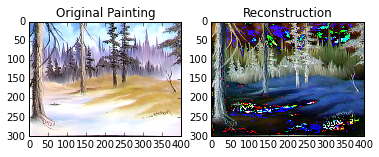

In [29]:
img_idx = 70
reconstructed_img = pca.inverse_transform(reduced_paintings[img_idx,:])
original_img = br_paintings[70,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (300, 400, 3)))
ax1.set_title("Original Painting")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (300, 400, 3)))
ax2.set_title("Reconstruction")
plt.show()

We can also visualize the transformation matrix $\mathbf{W}^{T}$.  It's rows act as 'filters' or 'feature detectors'...

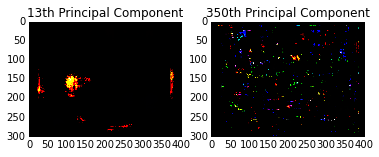

In [30]:
# get the transformation matrix
transformation_mat = pca.components_ # This is the W^T matrix
# two components to show
comp1 = 13
comp2 = 350

# subplot 
ax1 = plt.subplot(1,2,1)
filter1 = transformation_mat[comp1-1,:]
ax1.imshow(np.reshape(filter1, (300, 400, 3)))
ax1.set_title("%dth Principal Component"%(comp1))

# subplot 
ax2 = plt.subplot(1,2,2)
filter2 = transformation_mat[comp2-1,:]
ax2.imshow(np.reshape(filter2, (300, 400, 3)))
ax2.set_title("%dth Principal Component"%(comp2))
plt.show()

### 3.3 PCA for Visualization
PCA can also be done for visualization purposes.  Let's perform PCA on the movie ratings dataset and see if any semblence of the class structure can be seen.

In [32]:
# get the movie features
movie_features = movie_data[['RottenTomatoes','RottenTomatoes_User','Metacritic','Metacritic_User','Fandango_Ratingvalue']].as_matrix()

# perform standard scaling again but via SciKit-Learn
from sklearn.preprocessing import StandardScaler
z_scaler = StandardScaler()
movie_features = z_scaler.fit_transform(movie_features)

pca = PCA(n_components=2)
start_time = time.time()
movie_2d_proj = pca.fit_transform(movie_features)
end_time = time.time()

print "Training took a total of %.4f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(movie_2d_proj.shape)

Training took a total of 0.0008 seconds.
Preserved percentage of original variance: 91.21%
Dataset is now of size: 146 x 2


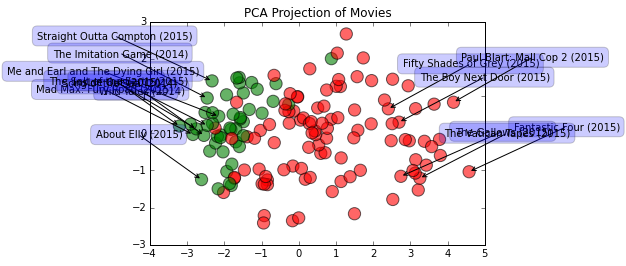

In [34]:
labels = movie_data['FILM'].tolist()
classes = movie_data['IMDB'].tolist()

# color the points by IMDB ranking
labels_to_show = []
colors = []
for idx, c in enumerate(classes):
    if c > 7.25:
        colors.append('g')
        if c > 8.:
            labels_to_show.append(labels[idx])
    else:
        colors.append('r')
        if c < 4.75:
            labels_to_show.append(labels[idx])

# plot data
plt.scatter(movie_2d_proj[:, 0], movie_2d_proj[:, 1], marker = 'o', c = colors, s = 150, alpha = .6)

# add movie title annotations
for label, x, y in zip(labels, movie_2d_proj[:, 0].tolist(), movie_2d_proj[:, 1].tolist()):
    if label not in labels_to_show:
        continue
    if x < 0:
        text_x = -20
    else:
        text_x = 150
    plt.annotate(label.decode('utf-8'),xy = (x, y), xytext = (text_x, 40),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0'),
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'b', alpha = 0.2))
    
plt.title('PCA Projection of Movies')
plt.show()

## <span style="color:red">STUDENT ACTIVITY (until end of session)</span> 
Your task is to reproduce the above PCA examples on a new dataset of images.  Let's load it...

Dataset size: 400 x 4096
And the images look like this...


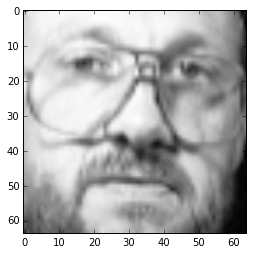

In [36]:
from sklearn.datasets import fetch_olivetti_faces

faces_dataset = fetch_olivetti_faces(shuffle=True)
faces = faces_dataset.data # 400 flattened 64x64 images
person_ids = faces_dataset.target # denotes the identity of person (40 total)

print "Dataset size: %d x %d" %(faces.shape)
print "And the images look like this..."
plt.imshow(np.reshape(faces[200,:], (64, 64)), cmap='Greys_r')
plt.show()

This dataset contains 400 64x64 pixel images of 40 people each exhibiting 10 facial expressions.  The images are in gray-scale, not color, and therefore flattened vectors contain 4096 dimensions.

### <span style="color:red">Subtask 1: Run PCA</span> 

In [37]:
?PCA

In [40]:
### Your code goes here ###

# train PCA model on 'faces'
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

start_time = time.time()
faces_reduced = pca.fit_transform(faces)
end_time = time.time()


###########################

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(faces_reduced.shape)

Training took a total of 0.19 seconds.
Preserved percentage of original variance: 93.54%
Dataset is now of size: 400 x 100


### <span style="color:red">Subtask 2: Reconstruct an image</span> 

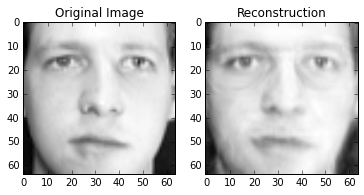

In [41]:
### Your code goes here ###

# Use learned transformation matrix to project back to the original 4096-dimensional space
# Remember you need to use np.reshape() 

###########################

img_idx = 70
reconstructed_img = pca.inverse_transform(faces_reduced[img_idx,:])
original_img = faces[70,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (64, 64)), cmap='Greys_r')
ax1.set_title("Original Image")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (64, 64)), cmap='Greys_r')
ax2.set_title("Reconstruction")
plt.show()


Your output should look something like what's below (although could be a different face):
![reconstruction_solution](./graphics/face_reconstruction_soln.png)

### <span style="color:red">Subtask 3: Visualize one or more components of the transformation matrix (W)</span> 

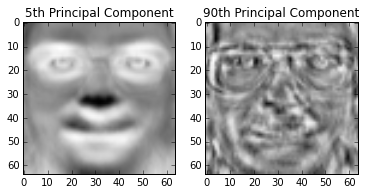

In [43]:
### Your code goes here ###

# Now visualize one of the principal components
# Again, remember you need to use np.reshape() 

###########################

transformation_mat = pca.components_
# two components to show
comp1 = 5
comp2 = 90

# subplot 
ax1 = plt.subplot(1,2,1)
filter1 = transformation_mat[comp1,:]
ax1.imshow(np.reshape(filter1, (64, 64)), cmap='Greys_r')
ax1.set_title("%dth Principal Component"%(comp1))

# subplot 
ax2 = plt.subplot(1,2,2)
filter2 = transformation_mat[comp2,:]
ax2.imshow(np.reshape(filter2, (64, 64)), cmap='Greys_r')
ax2.set_title("%dth Principal Component"%(comp2))
plt.show()

Your output should look something like what's below (although could have differently ranked components):
![reconstruction_solution](./graphics/face_components_soln.png)

### <span style="color:red">Subtask 4: Generate a 2D scatter plot</span> 

Training took a total of 0.21 seconds.
Preserved percentage of original variance: 37.81%
Dataset is now of size: 400 x 2


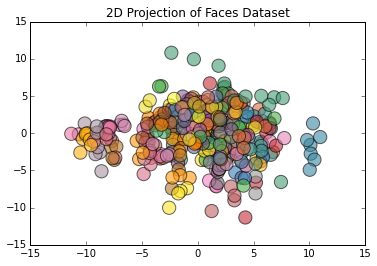

In [44]:
### Your code goes here ###

# Train another PCA model to project the data into two dimensions
# Bonus: color the scatter plot according to the person_ids to see if any structure can be seen

# Run PCA for 2 components

# Generate plot

###########################


pca = PCA(n_components=2)
start_time = time.time()
faces_2d_proj = pca.fit_transform(faces)
end_time = time.time()

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Preserved percentage of original variance: %.2f%%" %(pca.explained_variance_ratio_.sum() * 100) 
print "Dataset is now of size: %d x %d"%(faces_2d_proj.shape)

# Generate plot

# color the points by the person ids
colors = [plt.cm.Set1((c+1)/40.) for c in person_ids]

# plot data
plt.scatter(faces_2d_proj[:, 0], faces_2d_proj[:, 1], marker = 'o', c = colors, s = 175, alpha = .6)
plt.title('2D Projection of Faces Dataset')
plt.show()